In [2]:
# !pip install tensorflow --upgrade

In [3]:
import os
import numpy as np
import tensorflow as tf
import scipy.io as sio
from scipy.stats import beta
from tensorflow.random import set_seed
from scipy.stats import gaussian_kde as kde
import matplotlib.pyplot as plt

In [4]:
#######################################
#define the activation function
def rbf(x):
    return tf.math.exp(-x**2)

#######################################
#define the derivative of the activation function
def d_rbf(x):
    return tf.gradients(rbf,x)

#######################a################
#we couldn't use “tf_d_leaky_relu_6” as an activation function if we wanted to 
#because tensorflow doesn't know how to calculate the gradients of that function.
def rbf_grad(op, grad):
    x = op.inputs[0]
    n_gr = d_rbf(x)    #defining the gradient.
    return grad * n_gr

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+2))
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name, "PyFuncStateless": rnd_name}):
#     with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def tf_rbf(x,name=None):
    with tf.name_scope(name, "rbf", [x]) as name:
        y = py_func(rbf,   #forward pass function
                    [x],
                    [tf.float32],
                    name=name,
                    grad= rbf_grad) #the function that overrides gradient
        y[0].set_shape(x.get_shape())     #when using with the code, it is used to specify the rank of the input.
    return y[0]

## Example

$$ \frac{dy(t)}{dt} = -\lambda y, \ \  y(0)=1 $$
$$ y(t) = e^{-\lambda t} $$
$$QoI = y(0.5)$$
$\Lambda = (-\infty, \infty)$, $\mathcal{D}=(0,\infty)$

## MC vs PCE

In [28]:
import numpy as np
import timeit
import numpy.polynomial.hermite_e as H 
from math import factorial
from scipy.stats import norm
from scipy.integrate import odeint
from matplotlib import pyplot as plt

%matplotlib inline

## <font color =  red> Polynomial Chaos

In [29]:
start_def = timeit.default_timer()

def Phi(n):
    #define H_n
    coeffs = [0]*(n+1)
    coeffs[n] = 1
    return coeffs

def inner2_herm(n):       ###return the denominator when computing $k_i$
    return factorial(n)

def product3_herm(i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    return lambda x: H.hermeval(x, H.hermemul(H.hermemul(Phi(i),Phi(j)),Phi(l))) 

def inner3_herm(P,i,j,l):
    #compute <\Phi_i\Phi_j\Phi_l>
    
    #Set up Gauss-Hermite quadrature, weighting function is exp^{-x^2}
    m=(P+1)**2
    x, w=H.hermegauss(m)        
    inner=sum([product3_herm(i,j,l)(x[idx]) * w[idx] for idx in range(m)])         
    
    return inner/np.sqrt(2*np.pi)   #because of the weight

stop_def = timeit.default_timer()
time_def = stop_def - start_def
print('Time: ', time_def)

Time:  0.00025400519371032715


Fix $P=4$

In [30]:
start_prep = timeit.default_timer()

P=4
ki_herm = [0,1]+[0]*(P-1)
Inner3_herm = np.zeros((P+1,P+1,P+1)) #store all inner3_herm values
Inner2_herm = np.zeros(P+1)

for i in range(P+1):
    for j in range(P+1):
        for l in range(P+1):
            Inner3_herm[i,j,l] = inner3_herm(P,i,j,l)

for i in range(P+1):
    Inner2_herm[i] = inner2_herm(i)
            
stop_prep = timeit.default_timer()
time_prep = stop_prep - start_prep
print('Time: ', time_prep)

Time:  0.9306989759206772


In [31]:
start_ode = timeit.default_timer()

def ode_system_herm(y, t, P):   
    #P indicates the highest degree
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(Inner3_herm[i,j,l]*ki_herm[i]*y[j] for j in range(P+1)) for i in range(P+1)))/Inner2_herm[l]
    return dydt
            
stop_ode = timeit.default_timer()
time_ode = stop_ode - start_ode
print('Time: ', time_ode)

Time:  0.00015404820442199707


In [32]:
start_solveode = timeit.default_timer()

sol_herm = odeint(ode_system_herm, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, )) 

stop_solveode = timeit.default_timer()
time_solveode = stop_solveode - start_solveode
print('Time: ', time_solveode)

Time:  0.017740949988365173


In [33]:
time_all = time_def + time_prep + time_ode + time_solveode

## <font color =  red> Monte Carlo

In [35]:
start_ode_mc = timeit.default_timer()

def ode(y,t,nsample,k):
    '''
    Build the ode system
    '''
    dydt = np.zeros(nsample)
    for i in range(nsample):
        dydt[i] = -k[i]*y[i]
    return dydt

stop_ode_mc = timeit.default_timer()
time_def_mc = stop_ode_mc - start_ode_mc
print(time_def_mc)

8.840113878250122e-05


In [43]:
nsample = np.array([10, 100, 1000, 10000, 100000])
time_solveode_mc = np.zeros(len(nsample))
start_solveode_mc = np.zeros(len(nsample))
stop_solveode_mc = np.zeros(len(nsample))
mean_mc_1 = np.zeros(len(nsample))
mean_mc_05 = np.zeros(len(nsample))

for i in range(len(nsample)):
    k = norm.rvs(loc=0, scale=1, size=nsample[i], random_state=12345)
    start_solveode_mc[i] = timeit.default_timer()

    sol_mc = odeint(ode, [1.0]*nsample[i], np.linspace(0,1,101),args=(nsample[i],k))  #t:np.linspace(0,1,101)
    mean_mc_1[i] = np.mean(sol_mc[100,:])
    mean_mc_05[i] = np.mean(sol_mc[50,:])

    stop_solveode_mc[i] = timeit.default_timer()
    time_solveode_mc[i] = stop_solveode_mc[i] - start_solveode_mc[i]
    print(time_solveode_mc[i])

0.0011682026088237762
0.007946494966745377
0.08026570826768875
0.750608392059803
8.76984642073512


In [37]:
time_all_mc = time_def_mc + time_solveode_mc

## <font color = red> Computing time

In [38]:
print(time_solveode_mc)
print(time_solveode)     #pc

[9.32671130e-04 7.62957707e-03 7.87613839e-02 7.30410151e-01
 8.26153240e+00]
0.017740949988365173


In [39]:
time_all_mc

array([1.02107227e-03, 7.71797821e-03, 7.88497850e-02, 7.30498552e-01,
       8.26162080e+00])

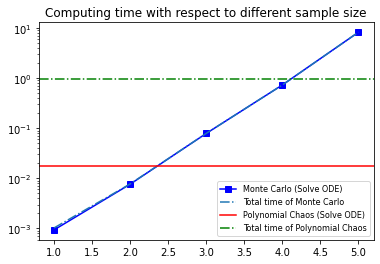

In [40]:
plt.figure()

plt.semilogy([1,2,3,4,5], time_solveode_mc,'-bs',label='Monte Carlo (Solve ODE)')
plt.semilogy([1,2,3,4,5], time_all_mc, linestyle='-.', label='Total time of Monte Carlo')
plt.axhline(y=time_solveode, color='r', linestyle='-', label='Polynomial Chaos (Solve ODE)')
plt.axhline(y=time_all, color='g', linestyle='-.', label='Total time of Polynomial Chaos')
#plt.plot([1,2,3,4,5], time_solveode,label='Polynomial Chaos')
plt.title('Computing time with respect to different sample size')
plt.legend(fontsize=8);

## <font color = red> Mean value at $t=1$, $t=0.5$
    
    
#### Sample size = 1000 for MC

In [44]:
# nsample = 1000
# k = norm.rvs(loc=0, scale=1, size=nsample, random_state=12345)
# sol_mc = odeint(ode, [1.0]*nsample, np.linspace(0,1,101),args=(nsample,k)) 
#sol_mc has shape (101, 1000), each col indicates one sample

## t = 1
mean_pc_1 = sol_herm[:,0][100]   #mean value using pc at t=1
# mean_mc_1 =  np.mean(sol_mc[100,:])
mean_exact_1 = np.e**(1/2)

## t = 0.5
mean_pc_05 = sol_herm[:,0][50]   #mean value using pc at t=0.5
# mean_mc_05 =  np.mean(sol_mc[50,:])
mean_exact_05 = np.e**(1/8)

In [45]:
print(mean_pc_1)
print(mean_mc_1)
print(mean_exact_1)

print()

print(mean_pc_05)
print(mean_mc_05)
print(mean_exact_05)

1.6486794979185284
[0.80759128 1.64191001 1.58804937 1.67483542 1.65016842]
1.6487212707001282

1.1331484337155744
[0.84243543 1.12379462 1.12573071 1.13969688 1.13387003]
1.1331484530668263


## <font color = red> Estimate the sample size needed to get the same accuracy

In [47]:
# nsample = 10000
print(mean_mc_1[-2])

1.6748354243693204


Sample size 10000 will reduce the difference and improve the accuracy, but still not stable

In [48]:
# nsample = 100000

print(mean_mc_1[-1])

1.6501684228940365


Even sample size 100000, still not very stable.

## <font color = red> Distribution of MC estimation
    
Estimate the mean value at t=1 for 100 times using MC

In [49]:
nsample = 10000
mean_mc_104 = np.zeros(100)  #mean value at t=1
for i in range(100):
    k = norm.rvs(loc=0, scale=1, size=nsample, random_state=i)
    sol_mc = odeint(ode, [1.0]*nsample, np.linspace(0,1,101),args=(nsample,k)) 
    mean_mc_104[i] =  np.mean(sol_mc[100,:])

Since the value got from PC and exact mean value are so close, we can only see one horizontal line.

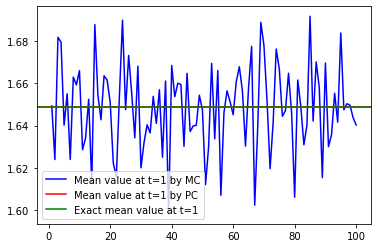

In [50]:
plt.figure()
x = np.linspace(1,100,100)
plt.plot(x, mean_mc_104, color='b',linestyle='-',label="Mean value at t=1 by MC")
plt.axhline(y=mean_pc_1, color='r', linestyle='-',label="Mean value at t=1 by PC")
plt.axhline(y=mean_exact_1, color='g', linestyle='-',label="Exact mean value at t=1")
plt.legend()

In [51]:
np.var(mean_mc_104)

0.0004065133864108975

In [52]:
np.std(mean_mc_104)

0.02016217712477741

## Stochastic Galerkin method, Stochastic collocation method, MC

## Poly vs NN

Finite difference:
$$
\frac{y_{i+1} - y_i}{\Delta t} = -\lambda y_i
$$
so
$$
y_{i+1} = -\lambda\Delta t y_i + y_i = (1-\lambda\Delta t)y_i
$$

Define $n := \frac{0.5}{\Delta t}$, then
$$
\hat{Q}(\lambda)=y(0.5) = y_n = (1-\lambda\Delta t)^n y_0 = (1-\lambda\Delta t)^n
$$

In [30]:
def Qexact(l):
    return np.exp(-l*0.5)

np.random.seed(12345)
size = 100
delta_t = 0.01
n = int(0.5/delta_t)
lam_in = np.random.normal(0, 1, size)
y_exact = np.array([np.exp(-i*0.5) for i in lam_in])
y_out = np.array([(1-i*delta_t)**n for i in lam_in])

In [31]:
num_neuron = 5
tf.random.set_seed(12345)
model_ode = tf.keras.Sequential()
model_ode.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_ode.add(tf.keras.layers.Dense(1))

model_ode.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_ode.fit(lam_in,y_out, epochs=1500, verbose=0)

In [33]:
preds_ode = []
for j in lam_in:
    preds_ode.append(model_ode.predict([j]))

preds_ode_shaped = tf.reshape(tf.constant(np.array(preds_ode)),len(preds_ode))
mse_fd_nn = tf.keras.losses.MSE(y_exact,preds_ode_shaped).numpy()
mse_fd_nn

0.00018785367

`curve_fit`

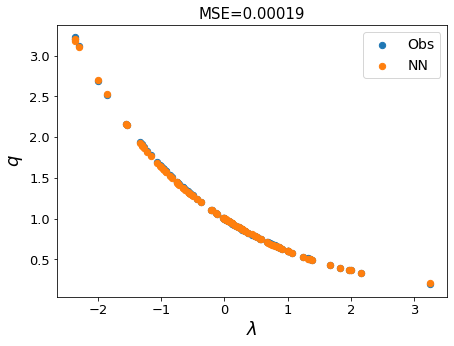

In [43]:
fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$\lambda$",fontsize=18)
plt.ylabel("$q$",fontsize=18)
plt.title("MSE=%.5f"%(mse_fd_nn),fontsize=15)
plt.scatter(lam_in, y_out, s=40, label='Obs')
plt.scatter(lam_in, preds_ode_shaped,s=40, label='NN')
plt.legend(prop={'size': 14});
fig.savefig("images/comp_fd_nn.png")

y = 1.00678 + -0.56691 * x + 0.12349 * x^2


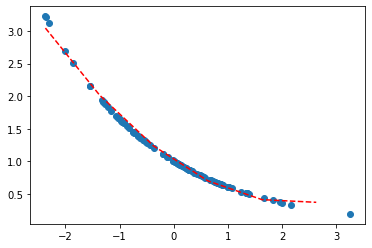

In [8]:
from scipy.optimize import curve_fit

# define the true objective function
def objective(x, a, b, c):
	return a + b * x + c * x**2 

# curve fit
popt, _ = curve_fit(objective, lam_in, y_out)
# summarize the parameter values
a, b, c = popt
print('y = %.5f + %.5f * x + %.5f * x^2' % (a, b, c))
# plot input vs output
plt.scatter(lam_in, y_out)
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(min(lam_in), max(lam_in), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '--', color='red')
plt.show()

`np.polyfit`

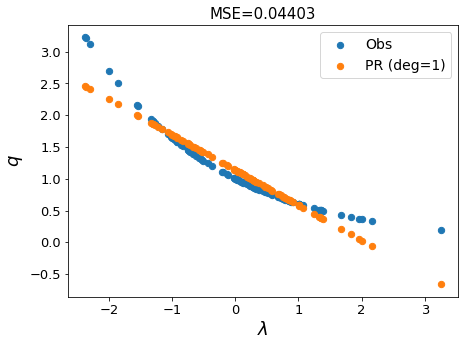

In [45]:
mymodel1 = np.poly1d(np.polyfit(lam_in, y_out, 1))
preds_fd_pr1 = mymodel1(lam_in)
mse_fd_pr1 = tf.keras.losses.MSE(y_exact,preds_fd_pr1).numpy()

fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$\lambda$",fontsize=18)
plt.ylabel("$q$",fontsize=18)
plt.title("MSE=%.5f"%(mse_fd_pr1),fontsize=15)
plt.scatter(lam_in, y_out, s=40, label='Obs')
plt.scatter(lam_in, preds_fd_pr1,s=40,label='PR (deg=1)')
plt.legend(prop={'size': 14});
fig.savefig("images/comp_fd_pr1.png")

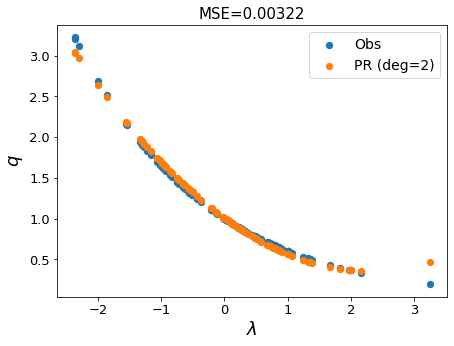

In [41]:
mymodel2 = np.poly1d(np.polyfit(lam_in, y_out, 2))
preds_fd_pr2 = mymodel2(lam_in)
mse_fd_pr2 = tf.keras.losses.MSE(y_exact,preds_fd_pr2).numpy()

fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$\lambda$",fontsize=18)
plt.ylabel("$q$",fontsize=18)
plt.title("MSE=%.5f"%(mse_fd_pr2),fontsize=15)
plt.scatter(lam_in, y_out, s=40, label='Obs')
plt.scatter(lam_in, preds_fd_pr2,s=40, label='PR (deg=2)')
plt.legend(prop={'size': 14});
fig.savefig("images/comp_fd_pr2.png")

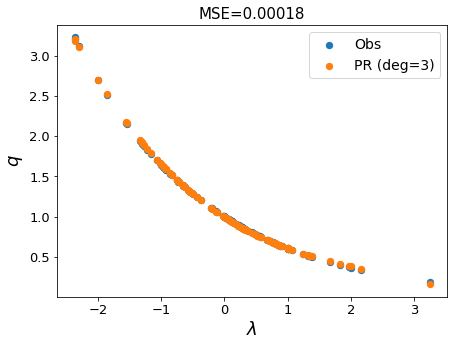

In [40]:
mymodel3 = np.poly1d(np.polyfit(lam_in, y_out, 3))
preds_fd_pr3 = mymodel3(lam_in)
mse_fd_pr3 = tf.keras.losses.MSE(y_exact,preds_fd_pr3).numpy()

fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$\lambda$",fontsize=18)
plt.ylabel("$q$",fontsize=18)
plt.title("MSE=%.5f"%(mse_fd_pr3),fontsize=15)
plt.scatter(lam_in, y_out, s=40, label='Obs')
plt.scatter(lam_in, preds_fd_pr3,s=40, label='PR (deg=3)')
plt.legend(prop={'size': 14});
fig.savefig("images/comp_fd_pr3.png")

`PolynomialFeatures`

In [27]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree = 3) 
# X_poly = poly.fit_transform(lam_in.reshape(-1,1)) 
# model = poly.fit(X_poly, y_out) 

# # print(poly.score(X_poly,y_out))
# # print(poly.intercept_,poly.coef_)
# plt.scatter(lam_in,y_out);
# # plt.plot(X_poly,model(X_poly))    #????

In [13]:
mymodel.coefficients

array([-0.01857442,  0.13642714, -0.50425523,  0.99340545])

In [20]:
def func(coef,x):
    sol = 0
    for i in range(len(coef)):
        sol += coef[-(i+1)]*x**i
    return sol

In [21]:
func(mymodel.coefficients,np.array([0,1]))

array([0.99340545, 0.60700293])

## Further discussions

<font color=red> Scaling, number of layers, print out the MSE every step, how to piecewise

In [5]:
def model(x):
    if x<=1:
        return 15*x+10
    elif x<=7:
        return x**3-12*x**2+36*x
    elif x<=10:
        return 15/np.pi*np.sin(np.pi*(x-7))+7
    else:
        return -30*np.sqrt(x-9)+37

In [6]:
np.random.seed(12345)
x_syn = np.random.uniform(0,15,100)
y_exact = np.array([model(i) for i in x_syn])
y_syn = y_exact+np.random.normal(0,1,len(x_syn))

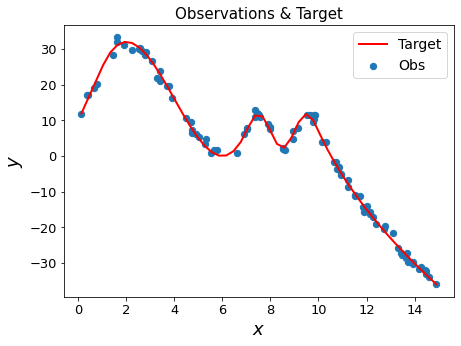

In [7]:
fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
plt.title('Observations & Target',fontsize=15)
x_plt = np.linspace(min(x_syn),max(x_syn),50)
y_plt = [model(i) for i in x_plt]
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.plot(x_plt, y_plt, color='red', linewidth=2, label='Target')
plt.legend(prop={'size': 14});
fig.savefig("images/comp_target.png")

## One-step method

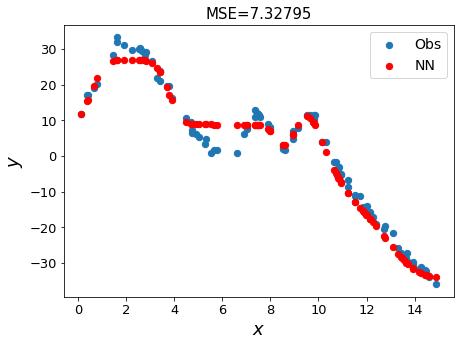

In [52]:
num_neuron = 5
tf.random.set_seed(12345)
model_syn_all = tf.keras.Sequential()
model_syn_all.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_syn_all.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
# model_syn_all.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
# model_syn_all.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_syn_all.add(tf.keras.layers.Dense(1))

model_syn_all.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_syn_all.fit(x_syn,y_syn, epochs=1000, verbose=0)

fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred = []
for j in x_syn:
    y_pred.append(model_syn_all.predict([j]))
y_pred_shaped = tf.reshape(tf.constant(np.array(y_pred)),len(y_pred))
error0 = tf.keras.losses.MSE(y_syn,y_pred_shaped).numpy()
plt.title("MSE=%.5f"%(error0),fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred_shaped, s=40, color='red',label="NN")
plt.legend(prop={'size': 14});
# fig.savefig("images/comp_nn_1step.png")

## Split-step Method

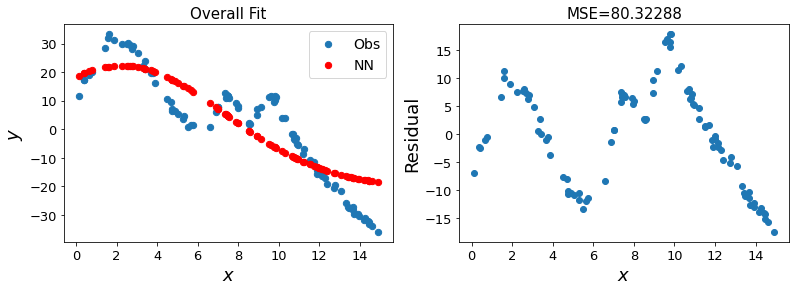

In [9]:
## Step 1

num_neuron = 5
tf.random.set_seed(12345)
model_nn1 = tf.keras.Sequential()
model_nn1.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_nn1.add(tf.keras.layers.Dense(1))

model_nn1.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_nn1.fit(x_syn,y_syn, epochs=1000, verbose=0)

fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred1 = []
for j in x_syn:
    y_pred1.append(model_nn1.predict([j]))
y_pred1_shaped = tf.reshape(tf.constant(np.array(y_pred1)),len(y_pred1))
plt.title("Overall Fit",fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred1_shaped, s=40, color='red',label="NN")
plt.legend(prop={'size': 14});
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
mse1 = tf.keras.losses.MSE(y_syn,y_pred1_shaped).numpy()
plt.title("MSE=%.5f"%(mse1),fontsize=15)
plt.scatter(x_syn, y_syn-y_pred1_shaped);
fig.savefig("images/comp_nn_step1.png");

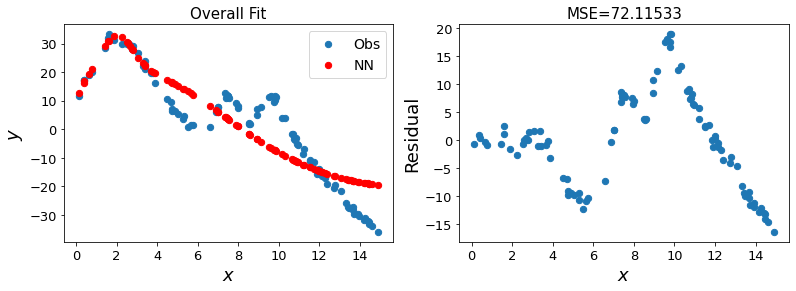

In [10]:
## Step 2

tf.random.set_seed(12345)
model_nn2 = tf.keras.Sequential()
model_nn2.add(tf.keras.layers.Dense(5,activation=rbf))
model_nn2.add(tf.keras.layers.Dense(1))

error1 = y_syn - y_pred1_shaped
model_nn2.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_nn2.fit(x_syn,error1, epochs=1000, verbose=0)

fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred2 = []
for j in x_syn:
    y_pred2.append(model_nn2.predict([j]))
y_pred2_shaped = tf.reshape(tf.constant(np.array(y_pred2)),len(y_pred2))
plt.title("Overall Fit",fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred1_shaped+y_pred2_shaped, s=40, color='red',label="NN")
plt.legend(prop={'size': 14});
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
mse2 = tf.keras.losses.MSE(y_syn,y_pred1_shaped+y_pred2_shaped).numpy()
plt.title("MSE=%.5f"%(mse2),fontsize=15)
plt.scatter(x_syn, y_syn-y_pred1_shaped-y_pred2_shaped, s=40);
fig.savefig("images/comp_nn_step2.png");

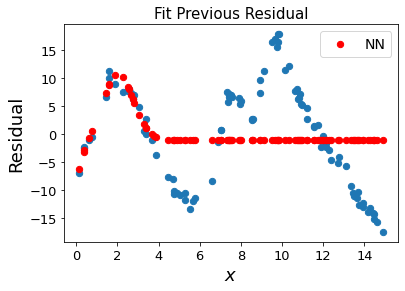

In [26]:
fig = plt.figure()
# plt.subplot(133)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
plt.title("Fit Previous Residual",fontsize=15)
plt.scatter(x_syn, error1, s=40)
plt.scatter(x_syn, y_pred2_shaped, s=40, color='red',label="NN")
plt.legend(prop={'size': 14});
fig.savefig("images/comp_nn_res2.png");

<font color=red>**I tried to use 'relu', but not much improvement. Maybe not enough training data??**

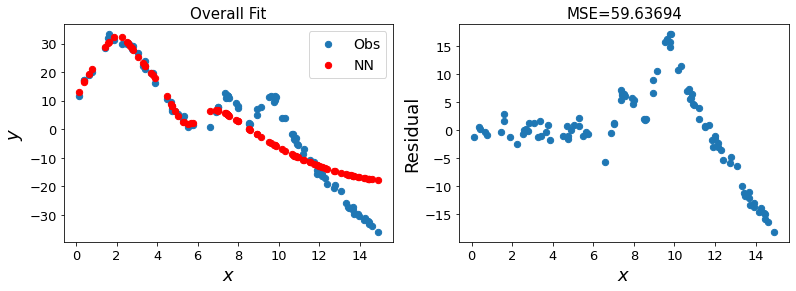

In [12]:
## Step 3

tf.random.set_seed(12345)
model_nn3 = tf.keras.Sequential()
model_nn3.add(tf.keras.layers.Dense(5,activation=rbf))
model_nn3.add(tf.keras.layers.Dense(1))

error2 = y_syn - y_pred1_shaped - y_pred2_shaped
model_nn3.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_nn3.fit(x_syn,error2, epochs=1000, verbose=0)

fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred3 = []
for j in x_syn:
    y_pred3.append(model_nn3.predict([j]))
y_pred3_shaped = tf.reshape(tf.constant(np.array(y_pred3)),len(y_pred3))
plt.title("Overall Fit",fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred1_shaped+y_pred2_shaped+y_pred3_shaped, s=40, color='red',label="NN")
plt.legend(prop={'size': 14});
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
mse3 = tf.keras.losses.MSE(y_syn,y_pred1_shaped+y_pred2_shaped+y_pred3_shaped).numpy()
plt.title("MSE=%.5f"%(mse3),fontsize=15)
plt.scatter(x_syn, y_syn-y_pred1_shaped-y_pred2_shaped-y_pred3_shaped,s=40);
fig.savefig("images/comp_nn_step3.png");

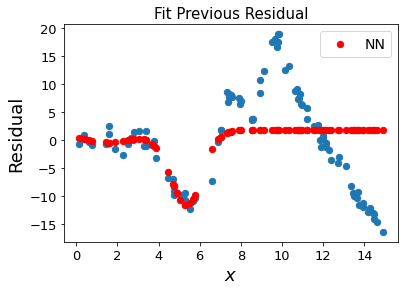

In [27]:
fig = plt.figure()
# plt.subplot(133)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
plt.title("Fit Previous Residual",fontsize=15)
plt.scatter(x_syn, error2, s=40)
plt.scatter(x_syn, y_pred3_shaped,s=40,color='red',label="NN")
plt.legend(prop={'size': 14});
fig.savefig("images/comp_nn_res3.png");

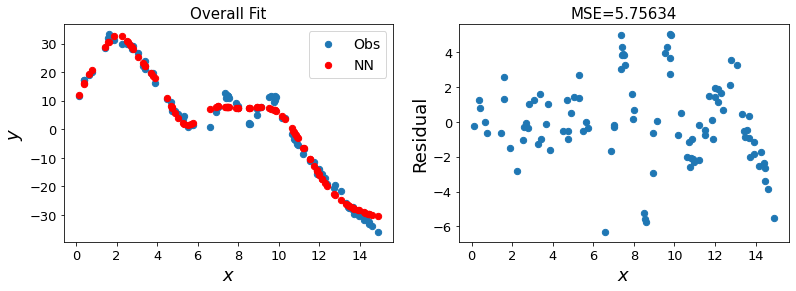

In [14]:
## Step 4

tf.random.set_seed(12345)
model_nn4 = tf.keras.Sequential()
model_nn4.add(tf.keras.layers.Dense(5,activation=rbf))
model_nn4.add(tf.keras.layers.Dense(1))

error3 = y_syn - y_pred1_shaped - y_pred2_shaped - y_pred3_shaped
model_nn4.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_nn4.fit(x_syn,error3, epochs=1000, verbose=0)

fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred4 = []
for j in x_syn:
    y_pred4.append(model_nn4.predict([j]))
y_pred4_shaped = tf.reshape(tf.constant(np.array(y_pred4)),len(y_pred4))
plt.title("Overall Fit",fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred1_shaped+y_pred2_shaped+y_pred3_shaped+y_pred4_shaped,s=40,color='red',label="NN")
plt.legend(prop={'size': 14});
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
mse4 = tf.keras.losses.MSE(y_syn,y_pred1_shaped+y_pred2_shaped+y_pred3_shaped+y_pred4_shaped).numpy()
plt.title("MSE=%.5f"%(mse4),fontsize=15)
plt.scatter(x_syn, y_syn-y_pred1_shaped-y_pred2_shaped-y_pred3_shaped-y_pred4_shaped,s=40);
fig.savefig("images/comp_nn_step4.png");

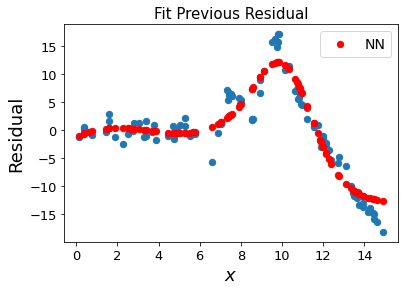

In [28]:
fig = plt.figure()
# plt.subplot(133)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
plt.title("Fit Previous Residual",fontsize=15)
plt.scatter(x_syn, error3, s=40)
plt.scatter(x_syn, y_pred4_shaped,s=40,color='red',label="NN")
plt.legend(prop={'size': 14});
fig.savefig("images/comp_nn_res4.png");

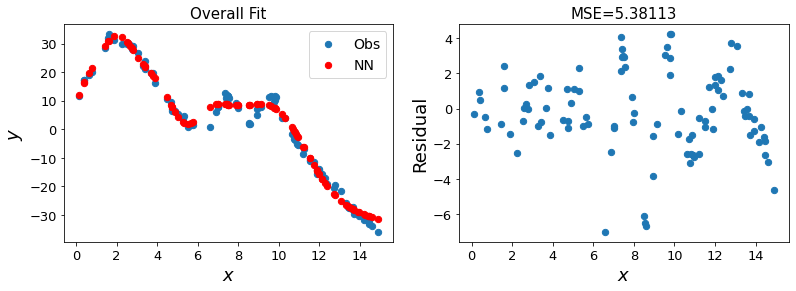

In [16]:
## Step 5

tf.random.set_seed(12345)
model_nn5 = tf.keras.Sequential()
model_nn5.add(tf.keras.layers.Dense(5,activation=rbf))
model_nn5.add(tf.keras.layers.Dense(1))

error4 = y_syn - y_pred1_shaped - y_pred2_shaped - y_pred3_shaped - y_pred4_shaped
model_nn5.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_nn5.fit(x_syn,error4, epochs=1000, verbose=0)

fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred5 = []
for j in x_syn:
    y_pred5.append(model_nn5.predict([j]))
y_pred5_shaped = tf.reshape(tf.constant(np.array(y_pred5)),len(y_pred5))
plt.title("Overall Fit",fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred1_shaped+y_pred2_shaped+y_pred3_shaped+y_pred4_shaped+y_pred5_shaped,s=40,color='red',label="NN")
plt.legend(prop={'size': 14});
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
mse5 = tf.keras.losses.MSE(y_syn,y_pred1_shaped+y_pred2_shaped+y_pred3_shaped+y_pred4_shaped+y_pred5_shaped).numpy()
plt.title("MSE=%.5f"%(mse5),fontsize=15)
plt.scatter(x_syn, y_syn-y_pred1_shaped-y_pred2_shaped-y_pred3_shaped-y_pred4_shaped-y_pred5_shaped,s=40);
fig.savefig("images/comp_nn_step5.png");

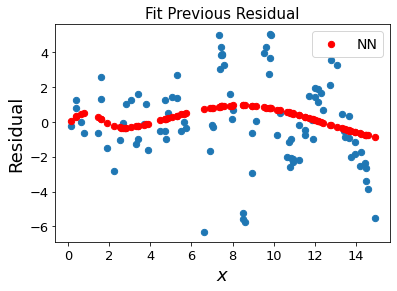

In [29]:
fig = plt.figure()
# plt.subplot(133)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
plt.title("Fit Previous Residual",fontsize=15)
plt.scatter(x_syn, error4, s=40)
plt.scatter(x_syn, y_pred5_shaped,s=40,color='red',label="NN")
plt.legend(prop={'size': 14});
fig.savefig("images/comp_nn_res5.png");

## 4 "151" = "1201"

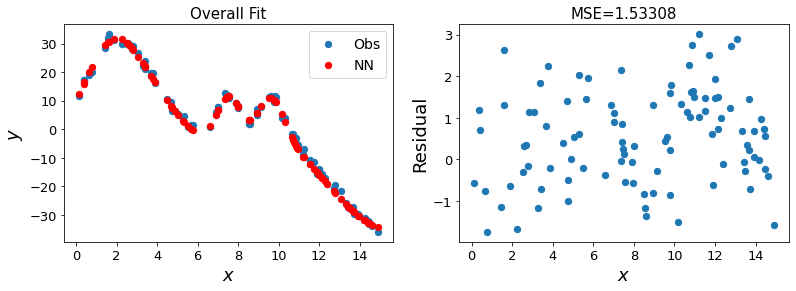

In [18]:
## Step 1

num_neuron = 20
tf.random.set_seed(12345)
model_nn11 = tf.keras.Sequential()
model_nn11.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_nn11.add(tf.keras.layers.Dense(1))

model_nn11.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_nn11.fit(x_syn,y_syn, epochs=5000, verbose=0)

fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred11 = []
for j in x_syn:
    y_pred11.append(model_nn11.predict([j]))
y_pred11_shaped = tf.reshape(tf.constant(np.array(y_pred11)),len(y_pred11))
plt.title("Overall Fit",fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred11_shaped,s=40,color='red',label="NN")
plt.legend(prop={'size': 14});
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
mse11 = tf.keras.losses.MSE(y_syn,y_pred11_shaped).numpy()
plt.title("MSE=%.5f"%(mse11),fontsize=15)
plt.scatter(x_syn, y_syn-y_pred11_shaped,s=40);
fig.savefig("images/comp_nn_step11.png");

## One-step Regression

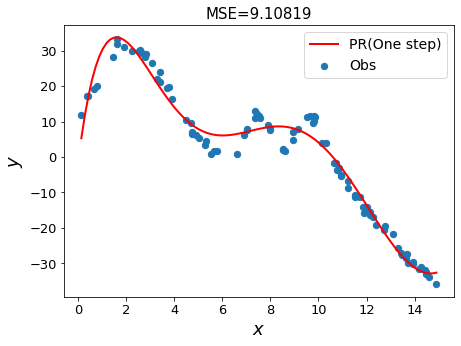

In [46]:
## one step
## Cannot capture info from 4 to 10
model_reg_all = np.poly1d(np.polyfit(x_syn, y_syn, 6))

x = np.linspace(min(x_syn), max(x_syn), 100)

fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
mse_pr=tf.keras.losses.MSE(y_syn,model_reg_all(x_syn)).numpy()
plt.title("MSE=%.5f"%(mse_pr),fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label="Obs")
plt.plot(x, model_reg_all(x),color='red', linewidth=2, label='PR(One step)');
plt.legend(prop={'size': 14});
fig.savefig("images/comp_pr_1step.png");

## Split-step Regression

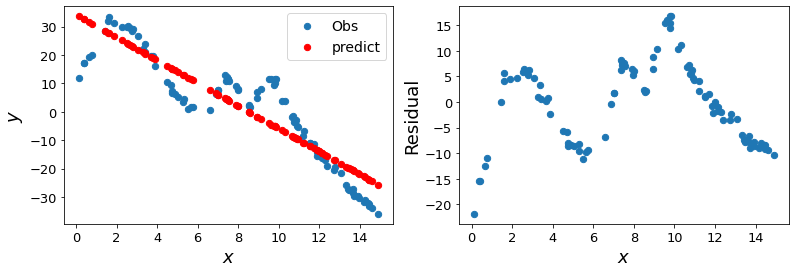

In [20]:
## step 1
model0 = np.poly1d(np.polyfit(x_syn, y_syn, 1))

# x = np.linspace(min(x_syn), max(x_syn), 100)

fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
pred0 = model0(x_syn)
plt.scatter(x_syn, pred0, s=40, color='red',label='predict')
plt.legend(prop={'size': 14})
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
# mse_pr1=tf.keras.losses.MSE(y_syn,pred0).numpy()
# plt.title("MSE=%.5f"%(mse_pr1),fontsize=15)
error0 = y_syn-pred0
plt.scatter(x_syn, error0, s=40);
fig.savefig("images/comp_pr_step1.png");

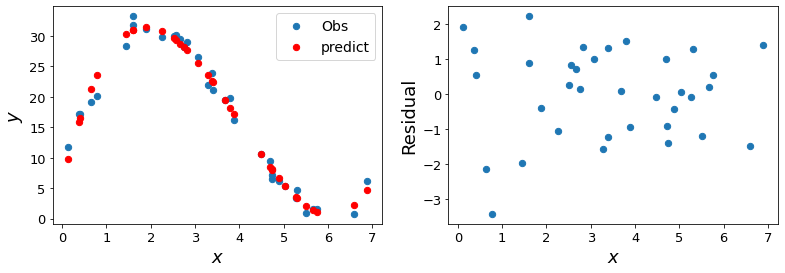

In [21]:
idx7 = x_syn<7
model7 = np.poly1d(np.polyfit(x_syn[idx7], error0[idx7], 3))   #only fit value < 7
fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
plt.scatter(x_syn[idx7], y_syn[idx7], s=40, label='Obs')                             #true obs
pred7 = model7(x_syn[idx7])
plt.scatter(x_syn[idx7], pred0[idx7]+pred7,s=40,color='red',label='predict') #predict of <7 part
plt.legend(prop={'size': 14})
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
error7 = y_syn[idx7]-pred0[idx7]-pred7               #error of <7 part
plt.scatter(x_syn[idx7], error7, s=40);
fig.savefig("images/comp_pr_step2.png");

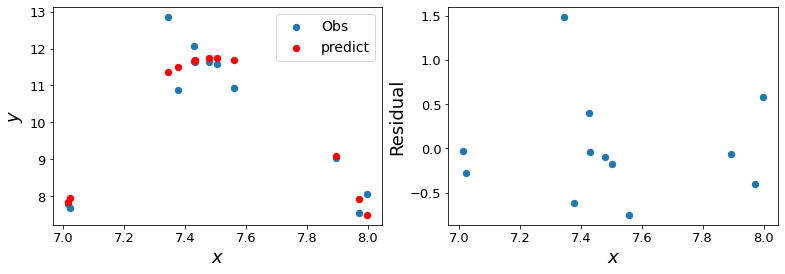

In [22]:
idx79 = [(i>=7) and (i<8.5) for i in x_syn]
model79 = np.poly1d(np.polyfit(x_syn[idx79], error0[idx79], 2))   #only fit value 7<9
fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
plt.scatter(x_syn[idx79], y_syn[idx79], s=40, label='Obs')                             #true obs
pred79 = model79(x_syn[idx79])
plt.scatter(x_syn[idx79], pred0[idx79]+pred79,s=40,color='red',label='predict') #predict of 7<9 part
plt.legend(prop={'size': 14})
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
error79 = y_syn[idx79]-pred0[idx79]-pred79               #error of 7<9 part
plt.scatter(x_syn[idx79], error79, s=40);
fig.savefig("images/comp_pr_step3.png");

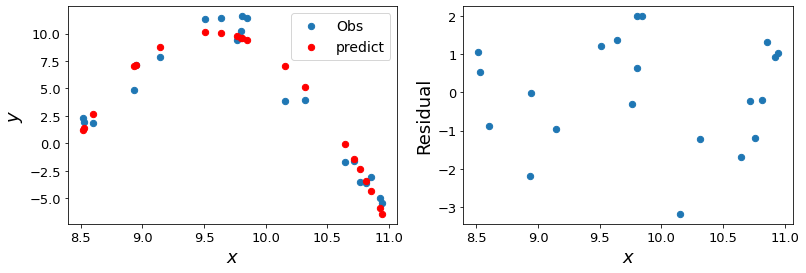

In [23]:
idx910 = [(i>=8.5) and (i<11) for i in x_syn]
model910 = np.poly1d(np.polyfit(x_syn[idx910], error0[idx910], 2))   #only fit value 7<9
fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
plt.scatter(x_syn[idx910], y_syn[idx910], s=40, label='Obs')                             #true obs
pred910 = model910(x_syn[idx910])
plt.scatter(x_syn[idx910], pred0[idx910]+pred910,s=40,color='red',label='predict') #predict of 7<9 part
plt.legend(prop={'size': 14})
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
error910 = y_syn[idx910]-pred0[idx910]-pred910               #error of 7<9 part
plt.scatter(x_syn[idx910], error910, s=40);
fig.savefig("images/comp_pr_step4.png");

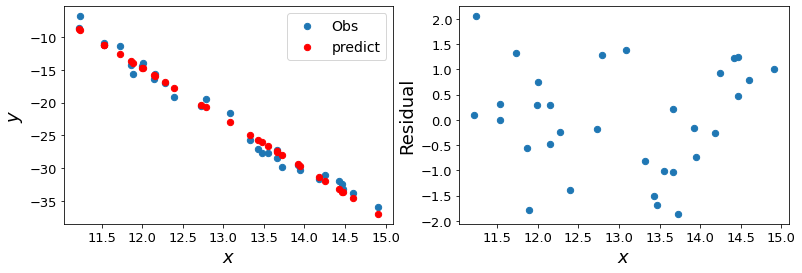

In [24]:
idx11 = (x_syn>=11)
model11 = np.poly1d(np.polyfit(x_syn[idx11], error0[idx11], 1))   #only fit value 7<9
fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
plt.scatter(x_syn[idx11], y_syn[idx11], s=40, label='Obs')                             #true obs
pred11 = model11(x_syn[idx11])
plt.scatter(x_syn[idx11], pred0[idx11]+pred11,s=40,color='red',label='predict') #predict of 7<9 part
plt.legend(prop={'size': 14})
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
error11 = y_syn[idx11]-pred0[idx11]-pred11               #error of 7<9 part
plt.scatter(x_syn[idx11], error11, s=40);
fig.savefig("images/comp_pr_step5.png");

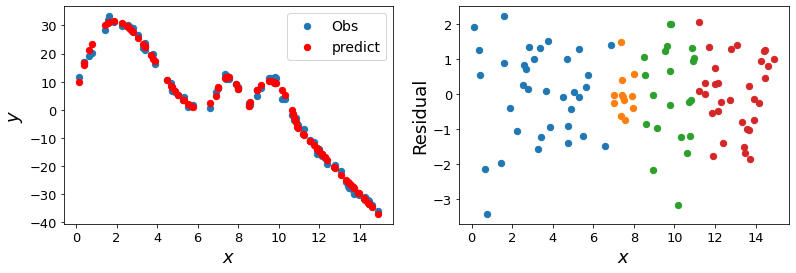

In [25]:
## Put together
fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
plt.scatter(x_syn, y_syn, s=40, label='Obs')       #obs
plt.scatter(x_syn[idx7], pred0[idx7]+pred7,s=40,color='red',label='predict') #predict of <7 part
plt.scatter(x_syn[idx79], pred0[idx79]+pred79,s=40,color='red') #predict of 7<8.5 part
plt.scatter(x_syn[idx910], pred0[idx910]+pred910,s=40,color='red') #predict of 8.5<11 part
plt.scatter(x_syn[idx11], pred0[idx11]+pred11,s=40,color='red') #predict of >11 part
plt.legend(prop={'size': 14});
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
plt.scatter(x_syn[idx7], error7, s=40)
plt.scatter(x_syn[idx79], error79, s=40)
plt.scatter(x_syn[idx910], error910, s=40)
plt.scatter(x_syn[idx11], error11, s=40);
fig.savefig("images/comp_pr_stepall.png");

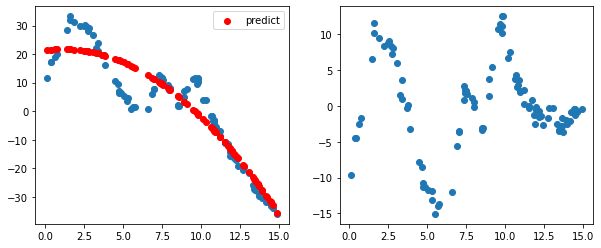

In [83]:
## step 2
model1 = np.poly1d(np.polyfit(x_syn, error0, 2))

# x = np.linspace(min(x_syn), max(x_syn), 100)

fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(x_syn, y_syn)
pred1 = model1(x_syn)
plt.scatter(x_syn, pred0+pred1,color='red',label='predict')
plt.legend()
plt.subplot(122)
error1 = y_syn-pred0-pred1
plt.scatter(x_syn, error1);

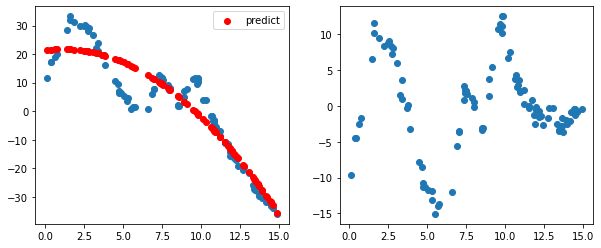

In [86]:
## step 3
model2 = np.poly1d(np.polyfit(x_syn, error1, 1))

# x = np.linspace(min(x_syn), max(x_syn), 100)

fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(x_syn, y_syn)
pred2 = model2(x_syn)
plt.scatter(x_syn, pred0+pred1+pred2,color='red',label='predict')
plt.legend()
plt.subplot(122)
error2 = y_syn-pred0-pred1-pred2
plt.scatter(x_syn, error2);

In [ ]:
x = [1,2,3,5,6,7,8,9,10,12,13,14,15,16,18,19,21,22]
y = [100,90,80,60,60,55,60,65,70,70,75,76,78,79,90,99,99,100]

mymodel = numpy.poly1d(numpy.polyfit(x, y, 3))

myline = numpy.linspace(1, 22, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.show()

`NN` & `PolynomialFeatures`

Comparison.ipynb

In [ ]:
# NN
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1))
x_expand = np.expand_dims(x,axis=1)
poly = PolynomialFeatures(4)
x_expand = poly.fit_transform(x_expand)
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1),metrics=['accuracy'])
model.fit(x_expand,y, epochs=100, verbose=0)

# mse = tf.keras.losses.MeanSquaredError()    #MeanAbsoluteError()
# mse(y,model.predict(x_expand)).numpy()

plt.figure()
plt.scatter(x,y,label='Training data')
plt.scatter(x,model.predict(x_expand),label='NN')
plt.legend();